# Configurations

In [1]:
from helper_functions import load_yx_dataframe
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [2]:
%matplotlib inline

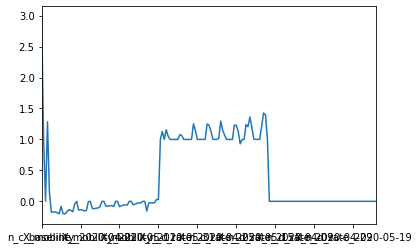

In [3]:
df = load_yx_dataframe(datetime.date(2020, 6, 16)).fillna(0)
cols_x_mobility = df.columns[df.columns.str.contains('X_mobility')]
cols_x_nconfirmed = df.columns[df.columns.str.contains('X_n_c_rate')]
cols_x_ndeaths = df.columns[df.columns.str.contains('X_n_d_rate')]
cols_x = cols_x_mobility.to_list() + cols_x_nconfirmed.to_list() + cols_x_ndeaths.to_list()
col_y = 'avg(n_d_rate)'
df.describe().loc['75%'].plot()

Reduce sparsity by removing those locations that have not reported any confirmed cases

In [4]:
df = df[~(df[cols_x_nconfirmed] == 0.0).all(axis = 1)]

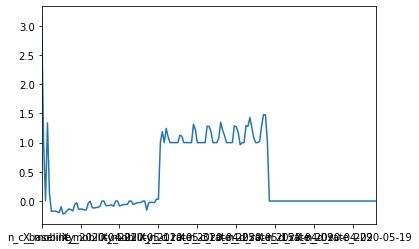

In [5]:
df.describe().loc['75%'].plot()

In [6]:
df['y_category'] = 1
df.loc[df[col_y] > 1.0, 'y_category'] = 2
df.loc[df[col_y] <= 0.0, 'y_category'] = 0
df['y_category'] = df['y_category'].astype('int64')
X = df[cols_x].copy()
Y_reg = df[col_y].copy()
Y_cls = df['y_category'].copy()

In [7]:
def weekify(df, columns, prefix):
    for week in range(1, len(columns) // 7 + 1):
        cols = columns[(week - 1) * 7: week * 7]        
        df[f'{prefix}_wk{week}'] = df[cols].mean(axis=1)
        df = df.drop(columns=cols)
    return df

X = weekify(X, cols_x_mobility.tolist(), 'x_mobility')
X = weekify(X, cols_x_nconfirmed.tolist(), 'x_nconfirmed')
X = weekify(X, cols_x_ndeaths.tolist(), 'x_ndeaths')

In [8]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, Y_reg, random_state=0)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, Y_cls, random_state=0)

from matplotlib import cm
cmap = cm.get_cmap('gnuplot')
scatter = pd.plotting.scatter_matrix(X_train[['X_mobility_2020-05-10', 'X_n_c_rate_2020-05-24','X_n_d_rate_2020-05-24']], 
                                     c=y_train, 
                                     marker = 'o', 
                                     s=30, 
                                     hist_kwds={'bins':10}, 
                                     figsize=(12,12), 
                                     cmap=cmap)

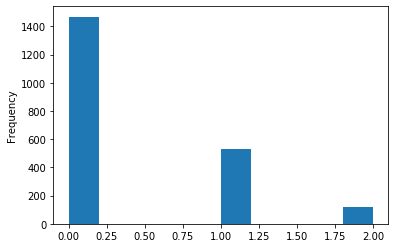

In [9]:
y_train_cls.plot.hist()

In [10]:
print('all 0 accuracy:', (y_train_cls == 0).sum() / len(y_train_cls))
print('all 1 accuracy:', (y_train_cls == 1).sum() / len(y_train_cls))
print('all 2 accuracy:', (y_train_cls == 2).sum() / len(y_train_cls))

all 0 accuracy: 0.6939064714218234
all 1 accuracy: 0.2512990080302315
all 2 accuracy: 0.0547945205479452


# Classification 

In [11]:
classifiers = {
    'dummy': DummyClassifier(random_state=0).fit(X_train_cls, y_train_cls),
    'logreg': LogisticRegression(random_state=0, solver='liblinear', multi_class='auto').fit(X_train_cls, y_train_cls),
    'svc': SVC(kernel='poly', degree=1, random_state=0, gamma='auto').fit(X_train_cls, y_train_cls),
    'k-NN': KNeighborsClassifier(n_neighbors=10).fit(X_train_cls, y_train_cls),
    'decision-tree': DecisionTreeClassifier(max_depth=10, random_state=0).fit(X_train_cls, y_train_cls)
}

for name, cls in classifiers.items():
    print(name, cls.score(X_test_cls, y_test_cls))

dummy 0.5439093484419264
logreg 0.8116147308781869
svc 0.8101983002832861
k-NN 0.8016997167138811
decision-tree 0.7450424929178471


In [12]:
classifiers = {
    'dummy': DummyClassifier(random_state=0),
    'logreg': LogisticRegression(random_state=0, solver='liblinear', multi_class='auto'),
    'svc': SVC(kernel='poly', degree=1, random_state=0, gamma='auto'),
    'k-NN': KNeighborsClassifier(n_neighbors=10),
    'decision-tree': DecisionTreeClassifier(max_depth=10, random_state=0)
}

for name, cls in classifiers.items():
    cv_scores = cross_val_score(cls, X, Y_cls, cv= 5)
    print(name, cv_scores.mean(), cv_scores)

dummy 0.5635734229895651 [0.5565371  0.59010601 0.55044248 0.56660746 0.55417407]
logreg 0.8069406360535114 [0.83215548 0.80388693 0.77699115 0.8365897  0.78507993]
svc 0.8083477695203729 [0.84275618 0.79681979 0.79115044 0.8330373  0.77797513]
k-NN 0.7899600642673087 [0.79681979 0.78091873 0.76460177 0.8294849  0.77797513]
decision-tree 0.7594998349549663 [0.73674912 0.76325088 0.7539823  0.78863233 0.75488455]


# Regression

In [13]:
regressor = {
    'dummy-reg': DummyRegressor().fit(X_train_cls, y_train_cls),
    'linear': LinearRegression().fit(X_train_cls, y_train_cls),
    'svr': SVR(kernel='poly', degree=1, gamma='auto').fit(X_train_cls, y_train_cls),
    'k-NN-reg': KNeighborsRegressor(n_neighbors=10).fit(X_train_cls, y_train_cls),
    'decision-tree-reg': DecisionTreeRegressor(max_depth=10, random_state=0).fit(X_train_cls, y_train_cls)
}

for name, reg in regressor.items():
    print(name, reg.score(X_test_reg, y_test_reg))

dummy-reg -0.15075035251132407
linear 0.3176101659839886
svr 0.46495931218323433
k-NN-reg 0.3005793254909529
decision-tree-reg -0.11995775688175159


In [14]:
regressor = {
    'dummy-reg': DummyRegressor(),
    'linear': LinearRegression(),
    'svr': SVR(kernel='poly', degree=1, gamma='auto'),
    'k-NN-reg': KNeighborsRegressor(n_neighbors=10),
    'decision-tree-reg': DecisionTreeRegressor(max_depth=10, random_state=0)
}

for name, reg in regressor.items():
    cv_scores = cross_val_score(reg, X, Y_reg, cv= 5)
    print(name, cv_scores.mean(), cv_scores)

dummy-reg -0.0946156531361801 [-0.07502741 -0.13990056 -0.00078554 -0.02648915 -0.23087561]
linear 0.4866971198218879 [0.53778265 0.56945776 0.52272603 0.4520839  0.35143526]
svr 0.6088123055438835 [0.44719833 0.67718024 0.60336073 0.63653959 0.67978263]
k-NN-reg 0.6112289637087377 [0.4611314  0.72964665 0.55721413 0.63608587 0.67206676]
decision-tree-reg -0.35691023758173807 [ 0.56242854  0.28655577 -0.56435402 -0.12947647 -1.93970501]
